# Multiarm Bandit

# Basic Imports

In [4]:
from typing import Iterable
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange


## The Environment — Process Model

### Simulating one Bandit

In [5]:
from abc import ABC, abstractmethod

Alternativa abstraktnim baznim klasama su protokoli.

https://godatadriven.com/blog/protocols-in-python-why-you-need-them/

In [6]:
class BanditBase(ABC):

    @abstractmethod
    def pull_leaver(self) -> float:
        pass

In [10]:
class Bandit(BanditBase):
    """A bandit with uniform reward distribution."""

    def __init__(self, mean: float, span: float):
        """Initialize the bandit.

        Regardless of the received action, the bandit will return reward
        uniformly sampled from segment [`mean`-`span`, `mean`+`span`].

        Args:
            mean (float): Mean (expected) value of the reward.
            span (float): Span of the reward.
        """
        self.mean = mean
        self.span = span

    def pull_leaver(self) -> float:
        """Pull leaver and obtain reward.

        Returns:
            float: The obtained reward.
        """
        return self.mean + 2*self.span * (random.random()-0.5)       

### Testing one Bandit

We should always test a piece of code :) This is not a formal test, but it is still a test.

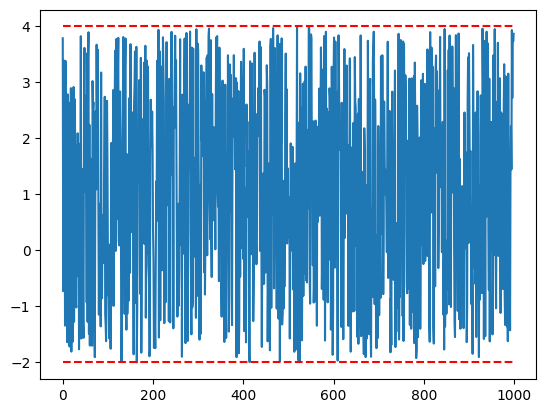

In [11]:
test_mean = 1.0
test_span = 3.0
test_len = 1000

test_bandit = Bandit(test_mean, test_span)
test_rewards = [test_bandit.pull_leaver() for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((test_mean+test_span)*np.ones(test_len), linestyle="--", color="r")
plt.plot((test_mean-test_span)*np.ones(test_len), linestyle="--", color="r")

### Building an Environment of Bandits

Now, we define an environment consisting of several bandits.

In [14]:
class EnvironmentBase(ABC):

    @abstractmethod
    def take_action(self, a: int) -> float:
        pass

In [15]:
class BanditsEnvironment(EnvironmentBase):
    """An environment consisting of multiple bandits."""

    def __init__(self, bandits: Iterable[BanditBase], penalty=1000):
        """Initialize the environment.

        Args:
            bandits (iter[Bandit]): Bandits to be used within the environment.
            penalty (int, optional): 
                If the external agents attempts to use a bandit not in the list,
                i.e. if the chosen action is negative or bigger than the index of
                the last bandit, the returned reward will be `-penalty`. Defaults to 1000.
        """
        self.bandits: list[BanditBase] = list(bandits)
        self.penalty = penalty

    def take_action(self, a: int):
        """
        Select bandit `a` and pull its leaver. 
        
        If the selected agent is valid, return the obtained reward.
        Otherwise, return negative penalty.
        """
        if a<0 or a>=len(self.bandits):
            return -self.penalty
        else:
            return self.bandits[a].pull_leaver()

<div class="alert alert-block alert-info">
<b>Tip:</b> 
The `Sequence` and `Iterable` **abstract base classes** (can also be used as **type annotations**) usually adhere to the following conventions:

* `Iterable` is any object that defines `__iter__` or `__getitem__`.
* `Sequence` is any object that defines `__getitem__` and `__len__`. By definition, any sequence is an iterable. 

The `Sequence` class also defines other methods such as `__contains__`, `__reversed__` that calls the two required methods.

`list`, `tuple`, `str` are the most common sequences. Some built-in iterables are not sequences.
</div>

For more tips and tricks regarding notebook markdown, please see [here](https://towardsdatascience.com/modernize-your-sinful-python-code-with-beautiful-type-hints-4e72e98f6bf1).


### Testing the Environment

Let us now test the environment. We will build it so that the mean value of the reward returned by each bandit is equal to the square of its index. The span will be equal to the index.

In [16]:
test_env_size = 5
test_bandits = [Bandit(i**2, i) for i in range(test_env_size)]
test_env = BanditsEnvironment(test_bandits)

We will first test whether one of the bandits behaves as expected...

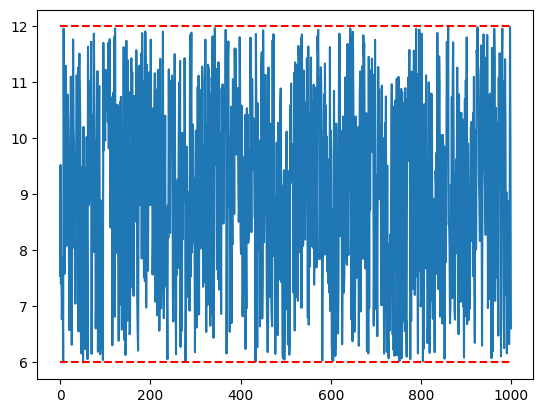

In [17]:
selected_bandit = 3
test_rewards = [test_env.take_action(selected_bandit) for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")
plt.plot((selected_bandit**2+selected_bandit)*np.ones(test_len), linestyle="--", color="r")
plt.plot((selected_bandit**2-selected_bandit)*np.ones(test_len), linestyle="--", color="r")

Then, we will test if the environment behaves correctly when an invalid action is given...

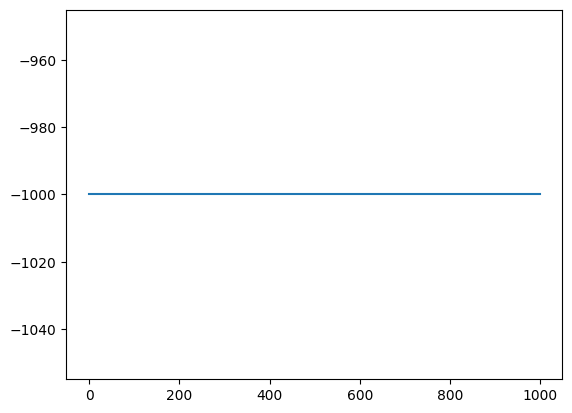

In [18]:
selected_bandit = -1
test_rewards = [test_env.take_action(selected_bandit) for _ in range(test_len)]

plt.plot(test_rewards, label="rewards")

Finally, let us check if the code runs with arbitrarily selected actions. This is quite tricky to do, since the whole system behaves stochastically. However, we know that the bandits are independent, and also that their mean values are 0, 1, 4, 9, and 16. Assuming each bandit is activated with the same probability, the mean value rewards obtained after many actions should be (0 + 1 + 4 + 9 + 16)/5 = 6.

In [23]:
test_len_long = 100*test_len
test_rewards = [test_env.take_action(random.randint(0, 4)) for _ in range(test_len_long)]
test_mean = sum(test_rewards)/test_len_long

print("TEST MEAN = ", test_mean)

TEST MEAN =  5.963126466160434


## Decision Policies

In [20]:
def choose_greedy_action(q):
    return np.argmax(q)

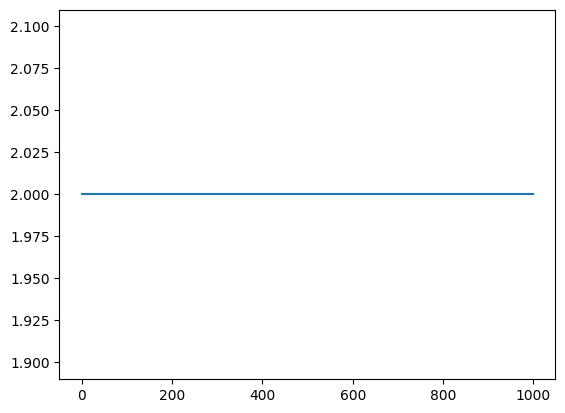

In [25]:
test_q = [1, 2, 3, 2, 1]

test_actions = [choose_greedy_action(test_q) for _ in range(test_len)]

plt.plot(test_actions)

In [33]:
def choose_random_action(n):
    return random.randint(0, n-1)

In [34]:
def choose_eps_greedy_action(q, eps):
    if random.random() > eps:
        return choose_greedy_action(q)
    else:
        return choose_random_action(len(q))

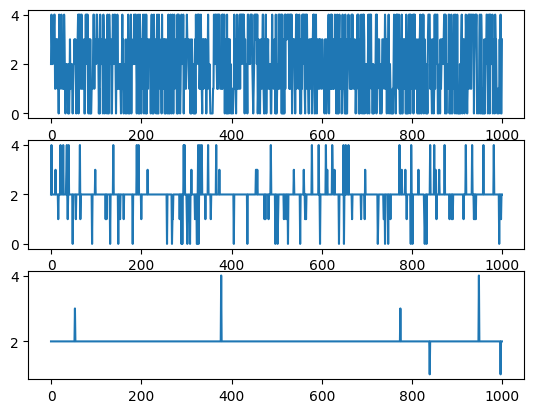

In [35]:
plt.subplot(3, 1, 1)
plt.plot([choose_eps_greedy_action(test_q, 1.0) for _ in range(test_len)])
plt.subplot(3, 1, 2)
plt.plot([choose_eps_greedy_action(test_q, 0.2) for _ in range(test_len)])
plt.subplot(3, 1, 3)
plt.plot([choose_eps_greedy_action(test_q, 0.01) for _ in range(test_len)])

## Training Loop

In [45]:
BANDITS_NO = 5
ATTEMPTS_NO = 5000
ALPHA = 0.1
EPSILON = 0.1

bandits = [Bandit(10*(random.random()-0.5), 5*random.random()) for _ in range(BANDITS_NO)]
env = BanditsEnvironment(bandits)

q = [100 for _ in range(BANDITS_NO)]
rewards = []
for t in trange(ATTEMPTS_NO):
    a = choose_eps_greedy_action(q, EPSILON)
    r = env.take_action(a)
    q[a] = q[a] + ALPHA * (r - q[a])
    
    # just for logging
    rewards.append(r)

  0%|          | 0/5000 [00:00<?, ?it/s]

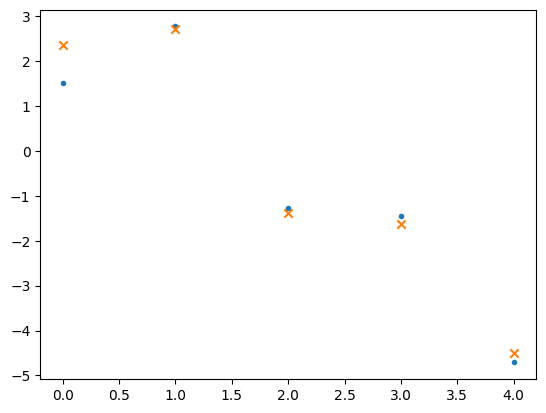

In [46]:
plt.scatter(range(len(q)), q, marker=".")
plt.scatter(range(len(q)), [b.mean for b in env.bandits], marker="x")

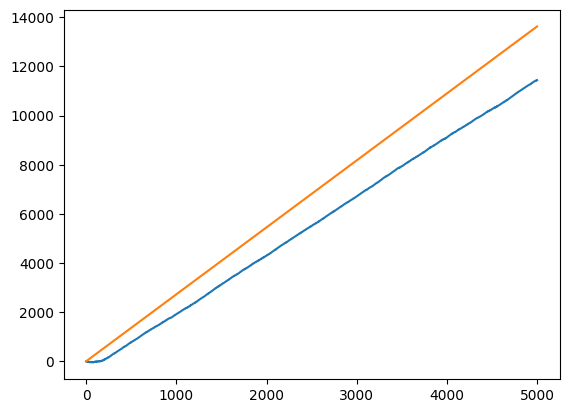

In [54]:
g = np.cumsum(rewards)
max_r = max([b.mean for b in env.bandits])
plt.plot(g)
plt.plot(np.cumsum(max_r * np.ones(len(g))))

1. Probati sa manjim epsilon, da se vidi da je manja razlika nagiba
2. Probati da uzmete nauceno q, i probati 100 iteracija sa epsilon = 0
3. Kako napraviti da se srednje vrednosti menjaju tokom vremena. Za pocetak samo da se nakon 4000 iteracija promene srednje vrednosti i spanovi bandita.